In [10]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
import math
import os
from tqdm.auto import tqdm

from skimage.io import imread, imshow
from skimage.transform import resize
from skimage.feature import hog, local_binary_pattern
import imgaug.augmenters as iaa
import pywt

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

from sklearn.pipeline import Pipeline
from sklearn.experimental import enable_halving_search_cv  # noqa
from sklearn.model_selection import HalvingGridSearchCV

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn import svm, metrics

In [6]:
df = pd.read_csv('./dataset/label.csv')
df.head()

,file_name,label
0,IMAGE_0000.jpg,meningioma_tumor
1,IMAGE_0001.jpg,no_tumor
2,IMAGE_0002.jpg,meningioma_tumor
3,IMAGE_0003.jpg,glioma_tumor
4,IMAGE_0004.jpg,meningioma_tumor


In [7]:
df['label'].value_counts()

glioma_tumor        860
meningioma_tumor    855
pituitary_tumor     831
no_tumor            454
Name: label, dtype: int64

In [8]:
def create_classes(df):
    '''
    Inputs
        df: Label data.
        
    Return
        classes: List of labels - 0 if no_tumor, 1 if glioma_tumor, 2 if meningioma_tumor, 3 if pituitary_tumor
    '''
    
    classes = []
    for label in df['label']:
        if 'no_tumor' in label:
            classes.append(0)
        elif 'glioma_tumor' in label:
            classes.append(1)
        elif 'meningioma_tumor' in label:
            classes.append(2)
        elif 'pituitary_tumor' in label:
            classes.append(3)
    return classes

In [11]:
data_path = './dataset/image'
images = []
for filename in tqdm(df['file_name']):
    im = imread(os.path.join(data_path, filename), as_gray=True)
    # DWT transforms image to (256,256) from (516,516), also for denoising
    coeffs = pywt.dwt2(im, 'haar')
    LL, (LH, HL, HH) = coeffs

    images.append(LL)

# Index of images with no_tumor label
noTumor_idx = df.index[df['label'] == 'no_tumor'].tolist()
# Index of images with glioma_tumor label
glioma_idx = df.index[df['label'] == 'glioma_tumor'].tolist()
# Index of images with meningioma_tumor label
meningioma_idx = df.index[df['label'] == 'meningioma_tumor'].tolist()

# List of images with no_tumor label
images_noTumor = []
for idx in noTumor_idx:
    images_noTumor.append(images[idx])

# Choose random indexes of images with glioma_tumor label up to 1/4 of the total number
glioma_idx_sample = random.choices(glioma_idx, k=math.floor(len(glioma_idx)/4))
# List of images with glioma_tumor label
images_glioma = []
for idx in glioma_idx_sample:
    images_glioma.append(images[idx])

# Choose random indexes of images with meningioma_tumor label up to 1/4 of the total number
meningioma_idx_sample = random.choices(
    meningioma_idx, k=math.floor(len(meningioma_idx)/4))
# List of images with meningioma_tumor label
images_meningioma = []
for idx in meningioma_idx_sample:
    images_meningioma.append(images[idx])

# Data Augmentation
seq = iaa.Sequential([
    iaa.Fliplr(0.5),  # horizontal flips
    iaa.Flipud(0.5),  # vertical flips
    # Small gaussian blur with random sigma between 0 and 0.5.
    # But we only blur about 50% of all images.
    iaa.Sometimes(
        0.5,
        iaa.GaussianBlur(sigma=(0, 0.5))
    ),
    iaa.Affine(
        rotate=(-180, 180),
        shear=(-10, 10)
    )
], random_order=True)

# Double the no_tumor images
images_aug_noTumor = seq(images=images_noTumor)
# Increases the glioma_tumor images by 1.25
images_aug_glioma = seq(images=images_glioma)
# Increases the meningioma_tumor images by 1.25
images_aug_meningioma = seq(images=images_meningioma)

# Concatenate the lists of image pixel data to form a new dataset with augmented images
images_new = images + images_aug_noTumor + \
    images_aug_glioma + images_aug_meningioma

  0%|          | 0/3000 [00:00<?, ?it/s]

In [28]:
def extract_hog(images_pixelData):
    '''
    Inputs
        images_pixelData: Dataset of image pixel data.

    Return
       hog_features: A list of HOG features for each image.
    '''
    hog_features = []

    for i in tqdm(range(len(images_pixelData))):
        resized_im = resize(images_pixelData[i], (128, 64))
        # Extract Histogram of Oriented Gradients (HOG) for the image
#         fd = hog(resized_im, orientations = 9, pixels_per_cell = (8, 8),
#                             cells_per_block = (2, 2), visualize = False, block_norm='L2-Hys')
        fd = hog(resized_im, orientations=9, pixels_per_cell=(8, 8),
                 cells_per_block=(4, 4), visualize=False, block_norm='L2-Hys')

        hog_features.append(fd)

    return hog_features


if os.path.exists('./dataset/label_taskB_hog.pkl'):
    print('The pickle file for Task B with HOG features data already exists')
else:
    classes = create_classes(df)
    hog_features = extract_hog(images_new)

    label_taskB = pd.DataFrame(data=hog_features)
    # classes: List of labels - 0 if no_tumor, 1 if glioma_tumor, 2 if meningioma_tumor, 3 if pituitary_tumor
    label_taskB['num_label'] = classes + [0] * \
        len(noTumor_idx) + [1]*len(glioma_idx_sample) + \
        [2]*len(meningioma_idx_sample)
    label_taskB.to_pickle("./dataset/label_taskB_hog.pkl")

  0%|          | 0/3882 [00:00<?, ?it/s]

In [14]:
def extract_lbp(images_pixelData, numPoints, radius):
    '''
    Inputs
        data_path: Directory path to images in dataset;
        df: Label data.

    Return
       lbp_features: A list of Local Binary Pattern (LBP) features for each image
    '''

    lbp_features = []
    for i in tqdm(range(len(images_pixelData))):
        # Extract Local Binary Pattern (LBP) for the image
        lbp = local_binary_pattern(
            images_pixelData[i], numPoints, radius, method="uniform")
        # Create bins for histogram
        n_bins = int(lbp.max() + 1)
        # Create histogram for image
        (hist, _) = np.histogram(lbp.ravel(), bins=n_bins, range=(0, n_bins))

        # # normalize the histogram
        # hist = hist.astype("float")
        # hist /= (hist.sum() + eps)

        lbp_features.append(hist)
    return lbp_features


if os.path.exists('./dataset/label_taskB_lbp.pkl'):
    print('The pickle file for Task B with lbp features data already exists')
else:
    classes = create_classes(df)
    lbp_features = extract_lbp(images_new, 24, 3)

    label_taskB = pd.DataFrame(data=lbp_features)
    # classes: List of labels - 0 if no_tumor, 1 if glioma_tumor, 2 if meningioma_tumor, 3 if pituitary_tumor
    label_taskB['num_label'] = classes + [0] * \
        len(noTumor_idx) + [1]*len(glioma_idx_sample) + \
        [2]*len(meningioma_idx_sample)
    label_taskB.to_pickle("./dataset/label_taskB_lbp.pkl")

  0%|          | 0/3882 [00:00<?, ?it/s]

In [18]:
def extract_multidwt(images_pixelData, levels):
    '''
    Inputs
        data_path: Directory path to images in dataset;
        df: Label data.

    Return
       multidwt: A list of Local Binary Pattern (LBP) features for each image
    '''
    multidwt = []
    for i in tqdm(range(len(images_pixelData))):
        LL = images_pixelData[i]
        for j in range(levels):
            coeffs = pywt.dwt2(LL, 'haar')
            LL, (LH, HL, HH) = coeffs

        multidwt.append(LL.ravel())

    return multidwt


if os.path.exists('./dataset/label_taskB_multidwt.pkl'):
    print('The pickle file for Task B image data transformed by DWT multiple times already exists')
else:
    classes = create_classes(df)
    multidwt = extract_multidwt(images_new, 2)

    label_taskB = pd.DataFrame(data=multidwt)
    # classes: List of labels - 0 if no_tumor, 1 if glioma_tumor, 2 if meningioma_tumor, 3 if pituitary_tumor
    label_taskB['num_label'] = classes + [0] * \
        len(noTumor_idx) + [1]*len(glioma_idx_sample) + \
        [2]*len(meningioma_idx_sample)
    label_taskB.to_pickle('./dataset/label_taskB_multidwt.pkl')

  0%|          | 0/3882 [00:00<?, ?it/s]

In [ ]:
# def PCAPredict(X_train, X_test, k):
#     '''
#     Inputs
#         X_train: Training dataset;
#         X_test: Testing dataset;
#         k: Number of components to use.
        
#     Return
#         X_train_PCA: Training dataset after applying PCA to reduce its dimensions;
#         X_test_PCA: Test dataset after applying PCA to reduce its dimensions.
#     '''

#     # the built-in function for PCA
#     pca = PCA(k)
    
#     # the built-in function to standardize features by removing the mean and scaling to unit variance
#     scaler = StandardScaler()

#     # fit the algorithm with dataset
    
#     scaler.fit(X_train)
#     X_train_scaled = scaler.transform(X_train)
#     X_test_scaled = scaler.transform(X_test)
    
#     pca.fit(X_train_scaled)
#     X_train_PCA = pca.transform(X_train_scaled)
#     X_test_PCA = pca.transform(X_test_scaled)
    
#     return X_train_PCA, X_test_PCA

In [29]:
feature = 'hog'

if feature == 'hog':
    # Doing classification with image HOG features
    label_taskB = pd.read_pickle("./dataset/label_taskB_hog.pkl")
elif feature == 'lbp':
    # Doing classification with image LBP features
    label_taskB = pd.read_pickle("./dataset/label_taskB_lbp.pkl")
elif feature == 'multidwt':
    # Doing classification with Multi-DWT image data
    label_taskB = pd.read_pickle("./dataset/label_taskB_multidwt.pkl")
elif feature == 'hoglbp':
    # Doing classification with image HOG and LBP features
    hog_features = pd.read_pickle("./dataset/label_taskB_hog.pkl")
    lbp_features = pd.read_pickle("./dataset/label_taskB_lbp.pkl")
    # Concatenate tables column-wise and remove extra 'num_label' column
    label_taskB = pd.concat(
        [hog_features.drop('num_label', axis=1), lbp_features], axis=1)
    
X = label_taskB.drop('num_label',axis=1) # All other features
Y = label_taskB['num_label'] # numerical label/classes

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.3, random_state = 3, shuffle=True, stratify=Y) 

print('train set: {}  | test set: {}'.format(round(((len(y_train)*1.0)/len(X)),3),
                                                       round((len(y_test)*1.0)/len(X),3)))

# the built-in function to standardize features by removing the mean and scaling to unit variance
scaler = StandardScaler()

# fit scaler to training dataset
scaler.fit(X_train)
# transform training and test dataset with fitted scaler
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

print(f'{X_train.shape[1]} features before PCA')
# Sanity check
print(('Train set mean = {mean:.2f}, Train set var = {var:.2f}').format(
    mean=X_train.mean(), var=X_train.var()))

train set: 0.7  | test set: 0.3
9360 features before PCA
Train set mean = -0.00, Train set var = 1.00


In [26]:
pd.Series(y_train).value_counts()

1    752
2    747
0    636
3    582
Name: num_label, dtype: int64

n_iterations: 6
n_required_iterations: 6
n_possible_iterations: 6
min_resources_: 84
max_resources_: 2717
aggressive_elimination: False
factor: 2
----------
iter: 0
n_candidates: 54
n_resources: 84
Fitting 5 folds for each of 54 candidates, totalling 270 fits
[CV 1/5] END pca__n_components=0.97, svc__C=1, svc__gamma=scale, svc__kernel=rbf;, score=(train=0.960, test=-0.026) total time=   0.0s
[CV 2/5] END pca__n_components=0.97, svc__C=1, svc__gamma=scale, svc__kernel=rbf;, score=(train=1.000, test=0.087) total time=   0.0s
[CV 3/5] END pca__n_components=0.97, svc__C=1, svc__gamma=scale, svc__kernel=rbf;, score=(train=0.941, test=0.300) total time=   0.0s
[CV 4/5] END pca__n_components=0.97, svc__C=1, svc__gamma=scale, svc__kernel=rbf;, score=(train=0.959, test=0.059) total time=   0.0s
[CV 5/5] END pca__n_components=0.97, svc__C=1, svc__gamma=scale, svc__kernel=rbf;, score=(train=0.960, test=0.211) total time=   0.0s
[CV 1/5] END pca__n_components=0.97, svc__C=1, svc__gamma=auto, svc__

[CV 3/5] END pca__n_components=0.99, svc__C=1, svc__gamma=scale, svc__kernel=rbf;, score=(train=0.980, test=0.300) total time=   0.0s
[CV 4/5] END pca__n_components=0.99, svc__C=1, svc__gamma=scale, svc__kernel=rbf;, score=(train=0.959, test=0.067) total time=   0.0s
[CV 5/5] END pca__n_components=0.99, svc__C=1, svc__gamma=scale, svc__kernel=rbf;, score=(train=0.960, test=0.125) total time=   0.0s
[CV 1/5] END pca__n_components=0.99, svc__C=1, svc__gamma=auto, svc__kernel=rbf;, score=(train=1.000, test=0.000) total time=   0.0s
[CV 2/5] END pca__n_components=0.99, svc__C=1, svc__gamma=auto, svc__kernel=rbf;, score=(train=1.000, test=0.000) total time=   0.0s
[CV 3/5] END pca__n_components=0.99, svc__C=1, svc__gamma=auto, svc__kernel=rbf;, score=(train=1.000, test=0.000) total time=   0.0s
[CV 4/5] END pca__n_components=0.99, svc__C=1, svc__gamma=auto, svc__kernel=rbf;, score=(train=1.000, test=0.000) total time=   0.0s
[CV 5/5] END pca__n_components=0.99, svc__C=1, svc__gamma=auto, sv

[CV 2/5] END pca__n_components=0.97, svc__C=10, svc__degree=3, svc__gamma=scale, svc__kernel=poly;, score=(train=1.000, test=0.000) total time=   0.0s
[CV 3/5] END pca__n_components=0.97, svc__C=10, svc__degree=3, svc__gamma=scale, svc__kernel=poly;, score=(train=1.000, test=0.205) total time=   0.0s
[CV 4/5] END pca__n_components=0.97, svc__C=10, svc__degree=3, svc__gamma=scale, svc__kernel=poly;, score=(train=1.000, test=0.000) total time=   0.0s
[CV 5/5] END pca__n_components=0.97, svc__C=10, svc__degree=3, svc__gamma=scale, svc__kernel=poly;, score=(train=1.000, test=0.174) total time=   0.0s
[CV 1/5] END pca__n_components=0.97, svc__C=10, svc__degree=3, svc__gamma=auto, svc__kernel=poly;, score=(train=1.000, test=0.000) total time=   0.0s
[CV 2/5] END pca__n_components=0.97, svc__C=10, svc__degree=3, svc__gamma=auto, svc__kernel=poly;, score=(train=1.000, test=0.000) total time=   0.0s
[CV 3/5] END pca__n_components=0.97, svc__C=10, svc__degree=3, svc__gamma=auto, svc__kernel=poly

[CV 4/5] END pca__n_components=0.98, svc__C=10, svc__degree=2, svc__gamma=auto, svc__kernel=poly;, score=(train=1.000, test=0.156) total time=   0.0s
[CV 5/5] END pca__n_components=0.98, svc__C=10, svc__degree=2, svc__gamma=auto, svc__kernel=poly;, score=(train=1.000, test=0.058) total time=   0.0s
[CV 1/5] END pca__n_components=0.98, svc__C=10, svc__degree=3, svc__gamma=scale, svc__kernel=poly;, score=(train=1.000, test=0.000) total time=   0.0s
[CV 2/5] END pca__n_components=0.98, svc__C=10, svc__degree=3, svc__gamma=scale, svc__kernel=poly;, score=(train=1.000, test=0.000) total time=   0.0s
[CV 3/5] END pca__n_components=0.98, svc__C=10, svc__degree=3, svc__gamma=scale, svc__kernel=poly;, score=(train=1.000, test=0.205) total time=   0.0s
[CV 4/5] END pca__n_components=0.98, svc__C=10, svc__degree=3, svc__gamma=scale, svc__kernel=poly;, score=(train=1.000, test=0.000) total time=   0.0s
[CV 5/5] END pca__n_components=0.98, svc__C=10, svc__degree=3, svc__gamma=scale, svc__kernel=pol

[CV 1/5] END pca__n_components=0.99, svc__C=10, svc__degree=2, svc__gamma=auto, svc__kernel=poly;, score=(train=1.000, test=0.000) total time=   0.0s
[CV 2/5] END pca__n_components=0.99, svc__C=10, svc__degree=2, svc__gamma=auto, svc__kernel=poly;, score=(train=1.000, test=0.159) total time=   0.0s
[CV 3/5] END pca__n_components=0.99, svc__C=10, svc__degree=2, svc__gamma=auto, svc__kernel=poly;, score=(train=1.000, test=0.437) total time=   0.0s
[CV 4/5] END pca__n_components=0.99, svc__C=10, svc__degree=2, svc__gamma=auto, svc__kernel=poly;, score=(train=1.000, test=0.059) total time=   0.0s
[CV 5/5] END pca__n_components=0.99, svc__C=10, svc__degree=2, svc__gamma=auto, svc__kernel=poly;, score=(train=1.000, test=0.098) total time=   0.0s
[CV 1/5] END pca__n_components=0.99, svc__C=10, svc__degree=3, svc__gamma=scale, svc__kernel=poly;, score=(train=1.000, test=0.000) total time=   0.0s
[CV 2/5] END pca__n_components=0.99, svc__C=10, svc__degree=3, svc__gamma=scale, svc__kernel=poly;,

[CV 5/5] END pca__n_components=0.99, svc__C=1, svc__gamma=scale, svc__kernel=rbf;, score=(train=0.950, test=0.266) total time=   0.0s
[CV 1/5] END pca__n_components=0.97, svc__C=1, svc__gamma=scale, svc__kernel=rbf;, score=(train=0.980, test=0.253) total time=   0.0s
[CV 2/5] END pca__n_components=0.97, svc__C=1, svc__gamma=scale, svc__kernel=rbf;, score=(train=0.950, test=0.378) total time=   0.0s
[CV 3/5] END pca__n_components=0.97, svc__C=1, svc__gamma=scale, svc__kernel=rbf;, score=(train=0.960, test=0.354) total time=   0.0s
[CV 4/5] END pca__n_components=0.97, svc__C=1, svc__gamma=scale, svc__kernel=rbf;, score=(train=0.940, test=0.478) total time=   0.0s
[CV 5/5] END pca__n_components=0.97, svc__C=1, svc__gamma=scale, svc__kernel=rbf;, score=(train=0.940, test=0.218) total time=   0.0s
[CV 1/5] END pca__n_components=0.98, svc__C=1, svc__gamma=scale, svc__kernel=rbf;, score=(train=0.980, test=0.253) total time=   0.0s
[CV 2/5] END pca__n_components=0.98, svc__C=1, svc__gamma=scal

[CV 1/5] END pca__n_components=0.99, svc__C=10, svc__degree=2, svc__gamma=scale, svc__kernel=poly;, score=(train=1.000, test=0.201) total time=   0.0s
[CV 2/5] END pca__n_components=0.99, svc__C=10, svc__degree=2, svc__gamma=scale, svc__kernel=poly;, score=(train=1.000, test=0.387) total time=   0.0s
[CV 3/5] END pca__n_components=0.99, svc__C=10, svc__degree=2, svc__gamma=scale, svc__kernel=poly;, score=(train=0.990, test=0.426) total time=   0.0s
[CV 4/5] END pca__n_components=0.99, svc__C=10, svc__degree=2, svc__gamma=scale, svc__kernel=poly;, score=(train=0.990, test=0.246) total time=   0.0s
[CV 5/5] END pca__n_components=0.99, svc__C=10, svc__degree=2, svc__gamma=scale, svc__kernel=poly;, score=(train=1.000, test=0.088) total time=   0.0s
[CV 1/5] END pca__n_components=0.97, svc__C=10, svc__gamma=scale, svc__kernel=rbf;, score=(train=1.000, test=0.287) total time=   0.0s
[CV 2/5] END pca__n_components=0.97, svc__C=10, svc__gamma=scale, svc__kernel=rbf;, score=(train=1.000, test=0

[CV 4/5] END pca__n_components=0.99, svc__C=100, svc__gamma=scale, svc__kernel=rbf;, score=(train=1.000, test=0.474) total time=   0.0s
[CV 5/5] END pca__n_components=0.99, svc__C=100, svc__gamma=scale, svc__kernel=rbf;, score=(train=1.000, test=0.265) total time=   0.0s
----------
iter: 2
n_candidates: 14
n_resources: 336
Fitting 5 folds for each of 14 candidates, totalling 70 fits
[CV 1/5] END pca__n_components=0.97, svc__C=100, svc__degree=2, svc__gamma=auto, svc__kernel=poly;, score=(train=1.000, test=0.394) total time=   0.1s
[CV 2/5] END pca__n_components=0.97, svc__C=100, svc__degree=2, svc__gamma=auto, svc__kernel=poly;, score=(train=1.000, test=0.456) total time=   0.1s
[CV 3/5] END pca__n_components=0.97, svc__C=100, svc__degree=2, svc__gamma=auto, svc__kernel=poly;, score=(train=1.000, test=0.434) total time=   0.1s
[CV 4/5] END pca__n_components=0.97, svc__C=100, svc__degree=2, svc__gamma=auto, svc__kernel=poly;, score=(train=1.000, test=0.480) total time=   0.1s
[CV 5/5] E

[CV 1/5] END pca__n_components=0.98, svc__C=10, svc__gamma=scale, svc__kernel=rbf;, score=(train=1.000, test=0.440) total time=   0.1s
[CV 2/5] END pca__n_components=0.98, svc__C=10, svc__gamma=scale, svc__kernel=rbf;, score=(train=1.000, test=0.387) total time=   0.2s
[CV 3/5] END pca__n_components=0.98, svc__C=10, svc__gamma=scale, svc__kernel=rbf;, score=(train=0.995, test=0.446) total time=   0.1s
[CV 4/5] END pca__n_components=0.98, svc__C=10, svc__gamma=scale, svc__kernel=rbf;, score=(train=0.995, test=0.406) total time=   0.1s
[CV 5/5] END pca__n_components=0.98, svc__C=10, svc__gamma=scale, svc__kernel=rbf;, score=(train=1.000, test=0.432) total time=   0.2s
[CV 1/5] END pca__n_components=0.99, svc__C=10, svc__gamma=scale, svc__kernel=rbf;, score=(train=1.000, test=0.422) total time=   0.1s
[CV 2/5] END pca__n_components=0.99, svc__C=10, svc__gamma=scale, svc__kernel=rbf;, score=(train=1.000, test=0.386) total time=   0.1s
[CV 3/5] END pca__n_components=0.99, svc__C=10, svc__ga

[CV 2/5] END pca__n_components=0.98, svc__C=10, svc__degree=2, svc__gamma=scale, svc__kernel=poly;, score=(train=1.000, test=0.693) total time=   5.6s
[CV 3/5] END pca__n_components=0.98, svc__C=10, svc__degree=2, svc__gamma=scale, svc__kernel=poly;, score=(train=0.999, test=0.766) total time=   5.5s
[CV 4/5] END pca__n_components=0.98, svc__C=10, svc__degree=2, svc__gamma=scale, svc__kernel=poly;, score=(train=1.000, test=0.656) total time=   5.7s
[CV 5/5] END pca__n_components=0.98, svc__C=10, svc__degree=2, svc__gamma=scale, svc__kernel=poly;, score=(train=1.000, test=0.700) total time=   5.8s
[CV 1/5] END pca__n_components=0.98, svc__C=100, svc__degree=2, svc__gamma=scale, svc__kernel=poly;, score=(train=1.000, test=0.617) total time=   5.6s
[CV 2/5] END pca__n_components=0.98, svc__C=100, svc__degree=2, svc__gamma=scale, svc__kernel=poly;, score=(train=1.000, test=0.693) total time=   5.6s
[CV 3/5] END pca__n_components=0.98, svc__C=100, svc__degree=2, svc__gamma=scale, svc__kerne

,params,mean_train_score,mean_test_score,rank_test_score
106,"{'pca__n_components': 0.98, 'svc__C': 100, 'svc__degree': 2, 'svc__gamma': 'scale', 'svc__kernel': 'poly'}",1.000000,0.783702,1
107,"{'pca__n_components': 0.99, 'svc__C': 100, 'svc__degree': 2, 'svc__gamma': 'scale', 'svc__kernel': 'poly'}",1.000000,0.781660,2
102,"{'pca__n_components': 0.99, 'svc__C': 100, 'svc__degree': 2, 'svc__gamma': 'scale', 'svc__kernel': 'poly'}",1.000000,0.693439,3
104,"{'pca__n_components': 0.98, 'svc__C': 100, 'svc__degree': 2, 'svc__gamma': 'scale', 'svc__kernel': 'poly'}",1.000000,0.689369,4
103,"{'pca__n_components': 0.98, 'svc__C': 10, 'svc__degree': 2, 'svc__gamma': 'scale', 'svc__kernel': 'poly'}",0.999751,0.687399,5
...,...,...,...,...
7,"{'pca__n_components': 0.98, 'svc__C': 1, 'svc__gamma': 'auto', 'svc__kernel': 'rbf'}",1.000000,0.000000,97
5,"{'pca__n_components': 0.97, 'svc__C': 100, 'svc__gamma': 'auto', 'svc__kernel': 'rbf'}",1.000000,0.000000,97
3,"{'pca__n_components': 0.97, 'svc__C': 10, 'svc__gamma': 'auto', 'svc__kernel': 'rbf'}",1.000000,0.000000,97
1,"{'pca__n_components': 0.97, 'svc__C': 1, 'svc__gamma': 'auto', 'svc__kernel': 'rbf'}",1.000000,0.000000,97


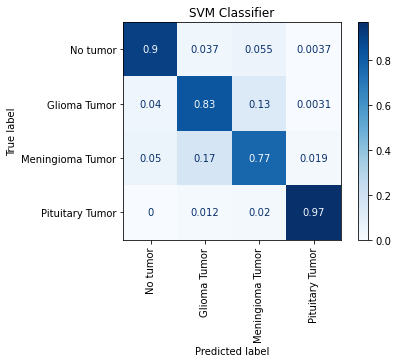

In [30]:
def SVMClassifierCV(X_train, y_train, X_test):
    '''
    Inputs
        X_train: Training dataset;
        y_train: Training labels;
        X_test: Testing dataset.

    Return
        Y_pred: Predicted labels from X_test using SVM.
    '''

    # Create dictionary of parameters to cross validate the estimator on
    # linear was considered in another function as kernel='linear' took very long to compute
    parameters = [
        {"svc__kernel": ["rbf"], "svc__gamma": ['scale', 'auto'], "svc__C": [1, 10, 100],
         "pca__n_components": [0.97, 0.98, 0.99]},
        {"svc__kernel": ["poly"], "svc__gamma": ['scale', 'auto'], "svc__C": [1, 10, 100], "svc__degree": [2, 3],
         "pca__n_components": [0.97, 0.98, 0.99]}
    ]
    
    matthews = metrics.make_scorer(metrics.matthews_corrcoef)

    # Create PCA object
    pca = PCA()
    # Create SVC object
    svc = svm.SVC(probability=True)

    pca_svc = Pipeline(steps=[('pca', pca), ('svc', svc)])

    # Exhaustive search over all chosen parameters
    clf = HalvingGridSearchCV(pca_svc,
                              parameters,
                              factor=2,
                              scoring=matthews,
                              refit=True,
                              verbose=4,
                              cv=5,
                              n_jobs=1,
                              random_state=42,
                              return_train_score=True)
    # Fit SVC model with the parameters for cross-validation
    clf.fit(X_train, y_train)
    # Predict labels with the best parameters from cross-validation
    print(clf.best_params_)

    results = pd.DataFrame.from_dict(
        clf.cv_results_).sort_values(by=['rank_test_score'])
    results = results[['params', 'mean_train_score',
                       'mean_test_score', 'rank_test_score']]

    # Predict labels with the best parameters from cross-validation
    Y_pred = clf.predict(X_test)

    fig, ax = plt.subplots()
    metrics.ConfusionMatrixDisplay.from_predictions(
        y_test,
        Y_pred,
        cmap=plt.cm.Blues,
        normalize='true',
        ax=ax,
        display_labels=['No tumor', 'Glioma Tumor', 'Meningioma Tumor', 'Pituitary Tumor'],
        xticks_rotation = 'vertical'
    )
    ax.set_title('SVM Classifier')

    return Y_pred, results

# classes: List of labels - 0 if no_tumor, 1 if glioma_tumor, 2 if meningioma_tumor, 3 if pituitary_tumor
Y_pred_SVM, results_SVM = SVMClassifierCV(X_train, y_train, X_test)
print(metrics.classification_report(
    y_test, Y_pred_SVM, target_names=['No tumor', 'Glioma Tumor', 'Meningioma Tumor', 'Pituitary Tumor']))
pd.set_option('display.max_colwidth', None)
display(results_SVM)

In [ ]:
# def KNNClassifierCV(X_train, y_train, X_test):
#     '''
#     Inputs
#         X_train: Training dataset;
#         y_train: Training labels;
#         X_test: Testing dataset;
        
#     Return
#         Y_pred: Predicted labels from X_test using K-Nearest Neighbour.
#     '''

#     # Create dictionary of parameters to cross validate the estimator on
#     parameters = [
#     {'algorithm': ['ball_tree'], 'n_neighbors':[1, 2, 3, 4], 'leaf_size':[10, 20, 30]},
#     {'algorithm': ['kd_tree'], 'n_neighbors':[1, 2, 3, 4], 'leaf_size':[10, 20, 30]},
#     {'algorithm': ['brute'], 'n_neighbors':[1, 2, 3, 4]}
#     ]

#     # Create KNN object
#     neigh = KNeighborsClassifier()
#     # Exhaustive search over all chosen parameters
#     clf = GridSearchCV(neigh, parameters, scoring='accuracy')
#     # Fit KNN model with the parameters for cross-validation
#     clf.fit(X_train, y_train) 
#     print(clf.best_params_)
#     # Predict labels with the best parameters from cross-validation
#     Y_pred = clf.predict(X_test)
    
#     disp = metrics.ConfusionMatrixDisplay.from_estimator(
#         clf,
#         X_test,
#         y_test,
#         cmap=plt.cm.Reds,
#         normalize='true'
#     )
#     disp.ax_.set_title('KNN Classifier')
    
#     return Y_pred, disp

# Y_pred_KNN, disp_KNN = KNNClassifierCV(X_train, y_train, X_test)
# score_KNN = metrics.accuracy_score(y_test, Y_pred_KNN)
# print('KNN classifier score:', score_KNN)

In [ ]:
# def RFClassifierCV(X_train, y_train, X_test):
#     '''
#     Inputs
#         X_train: Training dataset;
#         y_train: Training labels;
#         X_test: Testing dataset;
#         k: Number of trees in the forest.
        
#     Return
#         Y_pred: Predicted labels from X_test using Random Forests.
#     '''
#     # Create dictionary of parameters to cross validate the estimator on
#     parameters = {'n_estimators':[100, 200, 300], 'criterion':['entropy', 'gini'],
#     'max_features': ['sqrt', 'log2']}
#     # Create Random Forest object
#     RF = RandomForestClassifier()
#     # Exhaustive search over all chosen parameters
#     clf = GridSearchCV(RF, parameters, scoring='accuracy')
#     # Fit RF model with the parameters for cross-validation
#     clf.fit(X_train, y_train) 
#     print(clf.best_params_)
#     # Predict labels with the best parameters from cross-validation
#     Y_pred = clf.predict(X_test)

#     disp = metrics.ConfusionMatrixDisplay.from_estimator(
#         clf,
#         X_test,
#         y_test,
#         cmap=plt.cm.Greens,
#         normalize='true'
#     )
#     disp.ax_.set_title('Random Forest Classifier')
    
#     return Y_pred, disp

# Y_pred_RandomForest, disp_RF = RFClassifierCV(X_train, y_train, X_test)
# score_RandomForest = metrics.accuracy_score(y_test, Y_pred_RandomForest)
# print('Random Forest classifier score:', score_RandomForest)

In [ ]:
# def baggingClassifierML(X_train, y_train, X_test,k):

#     # Bagging takes Decision Tree as its base-estimator model by default.
#     bagmodel=BaggingClassifier(n_estimators=k,max_samples=0.5, max_features=4,random_state=1)
#     bagmodel.fit(X_train, y_train) # Fit KNN model


#     Y_pred = bagmodel.predict(X_test)
#     #print (Y_pred)
    
#     return Y_pred

In [ ]:
# def boostingClassifierML(X_train, y_train, X_test,k):
#     # AdaBoost takes Decision Tree as its base-estimator model by default.
#     boostmodel=AdaBoostClassifier(n_estimators=k)
#     boostmodel.fit(X_train, y_train,sample_weight=None) # Fit KNN model


#     Y_pred = boostmodel.predict(X_test)
#     #print (Y_pred)
#     return Y_pred

In [ ]:
# Y_pred_bagging = baggingClassifierML(X_train, y_train, X_test, 10)
# score_bagging = metrics.accuracy_score(y_test, Y_pred_bagging)

# Y_pred_boosting=boostingClassifierML(X_train, y_train, X_test, 10)
# score_boosting=metrics.accuracy_score(y_test, Y_pred_boosting)

# print('Bagging classifier score:', score_bagging)
# print('ADA Boosting classifier score:', score_boosting)